# Titanic Analysis

In [15]:
import numpy as np
from numpy.random import random_integers
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import pointbiserialr, spearmanr
get_ipython().magic('matplotlib inline')

## Load Data

In [16]:
df = pd.read_csv('../data/titan_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [18]:
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
}

In [19]:
df['Title'] = df['Name'].apply(lambda x: Title_Dictionary[x.split(',')[1].split('.')[0].strip()])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [20]:
def Ticket_Prefix(s):
    s = s.split()[0]
    if s.isdigit():
        return 'NoClue'
    else:
        return s

df['TicketPrefix'] = df['Ticket'].apply(lambda x: Ticket_Prefix(x))
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,NoClue
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NoClue


In [21]:
mask_Age = df.Age.notnull()
Age_Sex_Title_Pclass = df.loc[mask_Age, ["Age", "Title", "Sex", "Pclass"]]
Filler_Ages = Age_Sex_Title_Pclass.groupby(by = ["Title", "Pclass", "Sex"]).median()
Filler_Ages = Filler_Ages.Age.unstack(level = -1).unstack(level = -1)

mask_Age = df.Age.isnull()
Age_Sex_Title_Pclass_missing = df.loc[mask_Age, ["Title", "Sex", "Pclass"]]

In [22]:
def Age_filler(row):
    if row.Sex == "female":
        age = Filler_Ages.female.loc[row["Title"], row["Pclass"]]
        return age
    elif row.Sex == "male":
        age = Filler_Ages.male.loc[row["Title"], row["Pclass"]]
        return age

In [23]:
Age_Sex_Title_Pclass_missing["Age"] = Age_Sex_Title_Pclass_missing.apply(Age_filler, axis = 1)
df["Age"] = pd.concat([Age_Sex_Title_Pclass["Age"], Age_Sex_Title_Pclass_missing["Age"]])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,NoClue
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NoClue


In [24]:
df['Fare'].fillna(value = df.Fare.mean())
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,NoClue
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NoClue


In [25]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df = df.drop(['Ticket', 'Cabin'], axis = 1)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,TicketPrefix,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,A/5,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,PC,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,STON/O2.,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,NoClue,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,NoClue,0


In [26]:
dummies_Sex = pd.get_dummies(df['Sex'], prefix='Sex')
dummies_Embarked = pd.get_dummies(df['Embarked'], prefix = 'Embarked')
dummies_Pclass = pd.get_dummies(df['Pclass'], prefix = 'Pclass')
dummies_Title = pd.get_dummies(df['Title'], prefix = 'Title')
dummies_TicketPrefix = pd.get_dummies(df['TicketPrefix'], prefix = 'TicketPrefix')
df = pd.concat([df, dummies_Sex, dummies_Embarked, dummies_Pclass, dummies_Title, dummies_TicketPrefix], axis = 1)
df = df.drop(['Sex', 'Embarked', 'Pclass', 'Title', 'Name', 'TicketPrefix'], axis = 1)
df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,...,TicketPrefix_SOTON/O.Q.,TicketPrefix_SOTON/O2,TicketPrefix_SOTON/OQ,TicketPrefix_STON/O,TicketPrefix_STON/O2.,TicketPrefix_SW/PP,TicketPrefix_W./C.,TicketPrefix_W.E.P.,TicketPrefix_W/C,TicketPrefix_WE/P
0,1,0,22.0,1,0,7.2500,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,38.0,1,0,71.2833,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1,26.0,0,0,7.9250,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,1,35.0,1,0,53.1000,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,35.0,0,0,8.0500,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df = df.set_index(['PassengerId'])
df.head()

,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,TicketPrefix_SOTON/O.Q.,TicketPrefix_SOTON/O2,TicketPrefix_SOTON/OQ,TicketPrefix_STON/O,TicketPrefix_STON/O2.,TicketPrefix_SW/PP,TicketPrefix_W./C.,TicketPrefix_W.E.P.,TicketPrefix_W/C,TicketPrefix_WE/P
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,38.0,1,0,71.2833,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,35.0,1,0,53.1000,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
columns = df.columns.values
param = []
correlation = []
abs_corr = []

for c in columns:
    if len(df[c].unique())<=2:
        corr = spearmanr(df['Survived'], df[c])[0]
    else:
        corr = pointbiserialr(df['Survived'], df[c])[0]
    param.append(c)
    correlation.append(corr)
    abs_corr.append(abs(corr))

In [29]:
param_df = pd.DataFrame({'correlation': correlation, 'parameter': param, 'abs_corr': abs_corr})
param_df = param_df.sort_values(by=['abs_corr'], ascending=False)
param_df = param_df.set_index('parameter')
param_df.head()

,abs_corr,correlation
parameter,,
Survived,1.000000,1.000000
Title_Mr,0.549199,-0.549199
Sex_male,0.543351,-0.543351
Sex_female,0.543351,0.543351
Title_Mrs,0.344935,0.344935


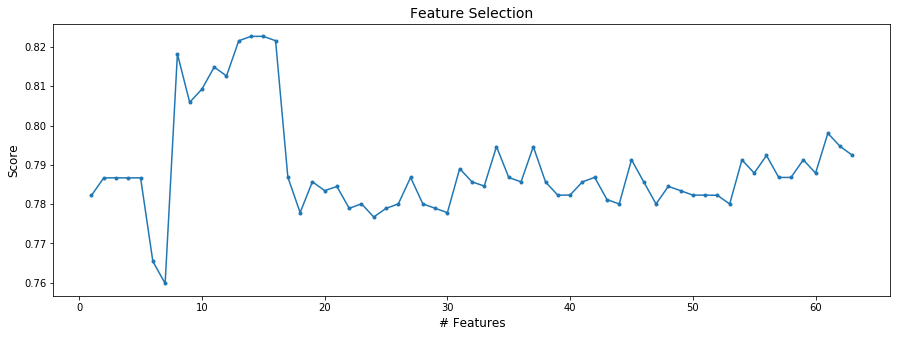

In [30]:
scoresCV = []
scores = []

for i in range(1,len(param_df)):
    new_df=df[param_df.index[0:i+1].values]
    X = new_df.ix[:,1::]
    y = new_df.ix[:,0]
    clf = DecisionTreeClassifier()
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
    
plt.figure(figsize=(15,5))
plt.plot(range(1,len(scores)+1),scores, '.-')
plt.axis("tight")
plt.title('Feature Selection', fontsize=14)
plt.xlabel('# Features', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.show()

In [31]:
best_features=param_df.index[1:10+1].values
print('Best features:\t',best_features)

Best features:	 ['Title_Mr' 'Sex_male' 'Sex_female' 'Title_Mrs' 'Title_Miss' 'Pclass_3'
 'Pclass_1' 'Fare' 'Embarked_C' 'Embarked_S']


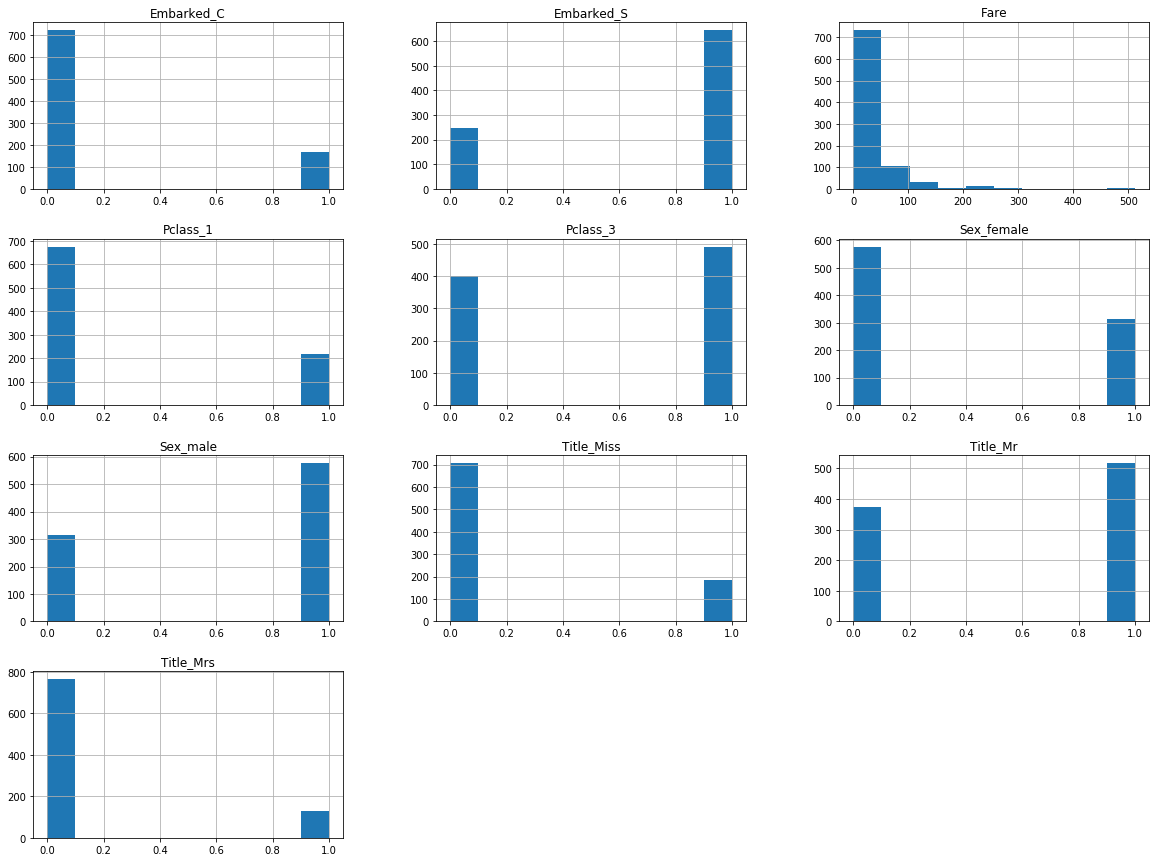

In [32]:
df[best_features].hist(figsize=(20,15));

X = df[best_features]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)

(-0.15000000000000002,
 3.1499999999999999,
 0.79027940926115081,
 0.81370793610259895)

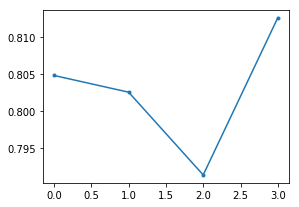

In [34]:
#Max Features
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(scores, '.-')
plt.axis('tight')

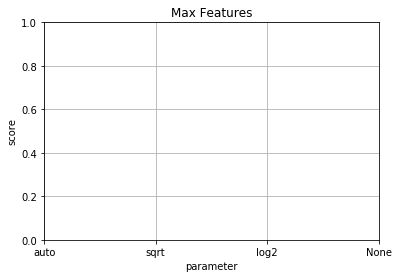

In [36]:
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

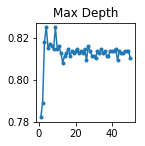

In [38]:
#Max Depth
plt.subplot(2,3,2)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.show()

ValueError: min_samples_split must be at least 2 or in (0, 1], got 1

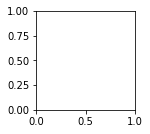

In [40]:
#Min Samples Split
plt.subplot(2,3,3)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.xlabel('parameter')
plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

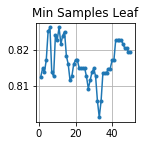

In [41]:
#Min Samples Leaf
plt.subplot(2,3,4)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Leaf')
plt.grid();

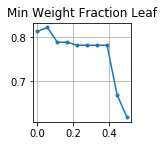

In [42]:
#Min Weight Fraction Leaf
plt.subplot(2,3,5)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

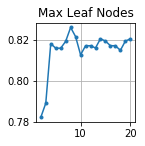

In [43]:
#Max Leaf Nodes
plt.subplot(2,3,6)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

